# 01. Pytorch Workflow Fundamentals

![Pytorch Workflow](./assets/01_a_pytorch_workflow.png)

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.8.0'

## 1. Data (preparing and loading)

![Data Preprocessing](./assets/01_data_preapring_and_loading.png)

Two Parts : 
1. Turn your data, whatever it is, into numbers (a representation)
2. Pick or build a model to learn the representation as best as possible.

known parameters: things that can be learned by a model

In [2]:
# let's create some data

# creating known parameters
weight = 0.7
bias = 0.3

# creating data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

print(X[:10], "\n", y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) 
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


Now we are going to build a model that can learn the relationship between X (features) and y (labels)

### Split data into training and test sets


| Split          | Total Data | 
|----------------|-----------|
| Training set   |60-80%     |
| Validation Set | 10-20%     |
| Testing Set    | 10-20%     |

In [3]:
# creating the training and testing splits
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


But right now our data is just numbers on a page.

Let's create a function to visualize it.



In [4]:
def plot_predictions(train_data=X_train,
                    train_label=y_train,
                    test_data = X_test,
                    test_label = y_test,
                    predictions = None):
    
    """Plots training data, test data and compares predictions"""
    plt.figure(figsize=(5,5))
    plt.scatter(train_data, train_label, c='b', s=4, label='Training Data')
    plt.scatter(test_data, test_label, c='g', s=4, label='Testing Data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 10})

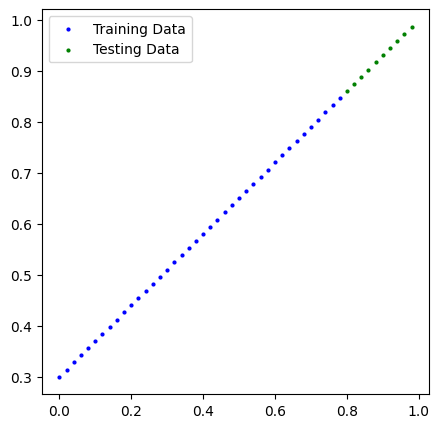

In [5]:
plot_predictions()

## 2. Build Model

![Pytorch Model building Essentials](./assets/01_model_building_essentials.png)

- nn.Module contains the larger building blocks (layers)
- nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
- forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
- torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data


In [6]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor :
        return self.weights*x + self.bias

![Model in Depth](./assets/01-pytorch-linear-model-annotated.png)

In [7]:
torch.manual_seed(42)

# Creating an instance of the model (which is a subclass of nn.Module that contains nn.Parameters)
model_0 = LinearRegressionModel()

# Check the nn.Parameters within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# We can also the get the `state` i.e. what the model contains using `.state_dict()`
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

In [9]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# """
# Or using this : 
# with torch.no_grad():
#     y_preds = model_0(X_test)
# """

We have used `torch.inference_mode()` as [`context manager`](https://realpython.com/python-with-statement/)

- As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

- torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In [10]:
# Check the predictions
print(f"Number of Testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted Values: \n{y_preds}")

Number of Testing samples: 10
Number of predictions made: 10
Predicted Values: 
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


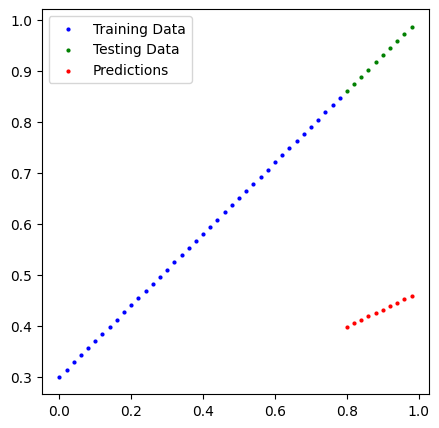

In [11]:
plot_predictions(predictions=y_preds)

In [12]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

## 3. Train Model

### Creating a Loss function and optimizer in Pytorch

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

![Loss Function and Optimizer](./assets/01_loss_function_and_optimizer_table.png)


We will use MAE as our Loss function and we'll use SGD, torch.optim.SGD(params, lr) where:

- `params` is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).

- `lr` is the learning rate you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a hyperparameter (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).


In [13]:
# creating the loss function
loss_fn = nn.L1Loss()       # MAE loss is same as L1Loss

# creating the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), # parameters of the target model to optimize
                        lr=0.01)



### Creating an Optimization Loop in Pytorch

- The training loop involves the model going through the training data and learning the relationships between the features and labels.

- The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never sees the testing data during training).

![Optimization Loop Song](./assets/01-pytorch-optimization-loop-song.png)

### Pytorch Training Loop

![Pytorch Training Loop](./assets/01_pytorch_training_loop.png)

![Pytorch Training Loop](./assets/01-pytorch-training-loop-annotated.png)

And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:

- Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).

- Zero gradients (optimizer.zero_grad()) before computing the gradients of the loss with respect to every model parameter (loss.backward()).

- Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).


### Pytorch Testing Loop

![Pytorch Testing Loop Table](./assets/01_pytorch_testing_loop_table.png)

![Pytorch Testing Loop Image](./assets/01-pytorch-testing-loop-annotated.png)

In [14]:
torch.manual_seed(42)
epochs = 200

# create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    # Put the model in training mode
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Test the new model for every epoch
    # Put the model in evaluation mode
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        # Predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")



Epoch: 0 | MAE Train Loss: 0.31288135051727295 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713389158249 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.2172965705394745
Epoch: 30 | MAE Train Loss: 0.053148530423641205 | MAE Test Loss: 0.14464019238948822
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953748226166
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633813381195
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937722325325
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.027887403964996338 | MAE Test Loss: 0.06473556160926819
Epoch: 100 | MAE Train Loss: 0.024458955973386765 | MAE Test Loss: 0.056463055312633514
Epoch: 110 | MAE Train Loss: 0.021020209416747093 | MAE Test Loss

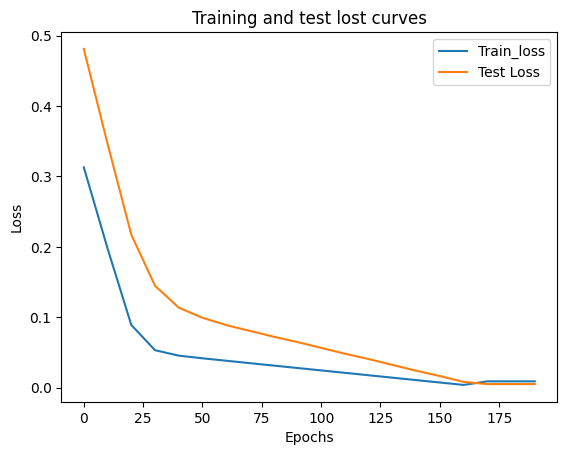

In [15]:
# PLot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train_loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test lost curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [16]:
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


## 4. Making Predictions with a trained pytorch model (inference)

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

- Set the model in evaluation mode (model.eval()).

- Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).

- All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).


In [17]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

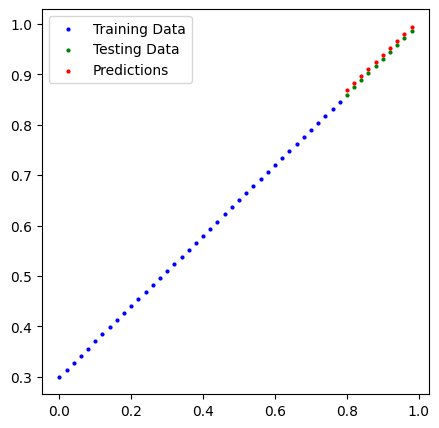

In [18]:
plot_predictions(predictions=y_preds)

## 5. Saving and Loading a Pytorch Model

![Pytorch saving and loading models guide](./assets/01_pytorch_saving_and_loading_model_guides.png)

### Saving a Pytorch Model's State Dict

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

Let's see how we can do that in a few steps:

- We'll create a directory for saving models to called models using Python's pathlib module.

- We'll create a file path to save the model to.

- We'll call `torch.save(obj, f)` where obj is the target model's state_dict() and f is the filename of where to save the model.


In [19]:
from pathlib import Path

# 1. creating the models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# save the model state dict
print(f"Saving Model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving Model to: models/01_pytorch_workflow_model_0.pth


In [20]:
# Check the saved file path
!ls -l models/


total 8
-rw-r--r--  1 qbit-glitch  staff  2117 27 Oct 15:20 01_pytorch_workflow_model_0.pth


### Loading a saved Pytorch model's `state_dict()`

Since we've now got a saved model state_dict() at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where f is the filepath of our saved model `state_dict()`.

**Why call torch.load() inside torch.nn.Module.load_state_dict()?**

- Because we only saved the model's state_dict() which is a dictionary of learned parameters and not the entire model, we first have to load the state_dict() with `torch.load()` and then pass that state_dict() to a new instance of our model (which is a subclass of nn.Module).



In [21]:
# instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state dict of our saved model    (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

Perform inference with the loaded model

In [23]:
loaded_model_0.eval()       # put the loaded model in evaluation mode
with torch.inference_mode():    # use the inference mode context manager to make predictios
    loaded_model_preds = loaded_model_0(X_test)     # perform a forward pass on the test data with the loaded model

In [24]:
# compare previous model predictions with loaded model predictions
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

Reference Material: [Loading and Saving Model in Pytorch](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html#saving-and-loading-models)